In [0]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 10

Processing...
Done!


## Common setup

In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [0]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [5]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.415965	Accuracy: 7.03125
Train: [12800/60000 (21%)]	Loss: 3.341144	Accuracy: 17.516850490196077
Train: [25600/60000 (43%)]	Loss: 1.748901	Accuracy: 26.949257425742573
Train: [38400/60000 (64%)]	Loss: 1.368178	Accuracy: 34.11372102649007
Train: [51200/60000 (85%)]	Loss: 1.040519	Accuracy: 41.6044776119403
Epoch: 1/20. Train set: Average loss: 1.7426	Accuracy: 44.961666666666666
Epoch: 1/20. Validation set: Average loss: 0.8934	Accuracy: 67.98
Train: [0/60000 (0%)]	Loss: 0.809470	Accuracy: 70.703125
Train: [12800/60000 (21%)]	Loss: 0.838839	Accuracy: 68.13725490196079
Train: [25600/60000 (43%)]	Loss: 0.774899	Accuracy: 69.60086633663366
Train: [38400/60000 (64%)]	Loss: 0.719906	Accuracy: 71.06270695364239
Train: [51200/60000 (85%)]	Loss: 0.711144	Accuracy: 72.11403917910448
Epoch: 2/20. Train set: Average loss: 0.7481	Accuracy: 72.73166666666667
Epoch: 2/20. Validation set: Average loss: 0.7383	Accuracy: 73.37
Train: [0/60000 (0%)]	Loss: 0.565132	Accuracy: 7


Train: [12800/60000 (21%)]	Loss: 0.261111	Accuracy: 91.14583333333333
Train: [25600/60000 (43%)]	Loss: 0.241453	Accuracy: 91.31729579207921
Train: [38400/60000 (64%)]	Loss: 0.257441	Accuracy: 91.27431705298014
Train: [51200/60000 (85%)]	Loss: 0.239581	Accuracy: 91.29741915422886
Epoch: 9/20. Train set: Average loss: 0.2482	Accuracy: 91.34333333333333
Epoch: 9/20. Validation set: Average loss: 0.3429	Accuracy: 90.02
Train: [0/60000 (0%)]	Loss: 0.205705	Accuracy: 94.53125
Train: [12800/60000 (21%)]	Loss: 0.227442	Accuracy: 92.13388480392157
Train: [25600/60000 (43%)]	Loss: 0.231766	Accuracy: 91.91290222772277
Train: [38400/60000 (64%)]	Loss: 0.223850	Accuracy: 91.9908940397351
Train: [51200/60000 (85%)]	Loss: 0.229008	Accuracy: 91.99898942786069
Epoch: 10/20. Train set: Average loss: 0.2266	Accuracy: 92.00833333333334
Epoch: 10/20. Validation set: Average loss: 0.3469	Accuracy: 90.05
Train: [0/60000 (0%)]	Loss: 0.202942	Accuracy: 92.1875
Train: [12800/60000 (21%)]	Loss: 0.210038	Accurac

Train: [25600/60000 (43%)]	Loss: 0.160992	Accuracy: 94.23731435643565
Train: [38400/60000 (64%)]	Loss: 0.154454	Accuracy: 94.40707781456953
Train: [51200/60000 (85%)]	Loss: 0.157355	Accuracy: 94.41853233830845
Epoch: 17/20. Train set: Average loss: 0.1588	Accuracy: 94.32666666666667
Epoch: 17/20. Validation set: Average loss: 0.3985	Accuracy: 90.77
Train: [0/60000 (0%)]	Loss: 0.105358	Accuracy: 96.09375
Train: [12800/60000 (21%)]	Loss: 0.159356	Accuracy: 94.35508578431373
Train: [25600/60000 (43%)]	Loss: 0.155861	Accuracy: 94.31466584158416
Train: [38400/60000 (64%)]	Loss: 0.155974	Accuracy: 94.38379552980132
Train: [51200/60000 (85%)]	Loss: 0.154903	Accuracy: 94.37577736318408
Epoch: 18/20. Train set: Average loss: 0.1555	Accuracy: 94.41666666666667
Epoch: 18/20. Validation set: Average loss: 0.4074	Accuracy: 90.72
Train: [0/60000 (0%)]	Loss: 0.217820	Accuracy: 92.1875
Train: [12800/60000 (21%)]	Loss: 0.148904	Accuracy: 94.56954656862744
Train: [25600/60000 (43%)]	Loss: 0.153504	Accur

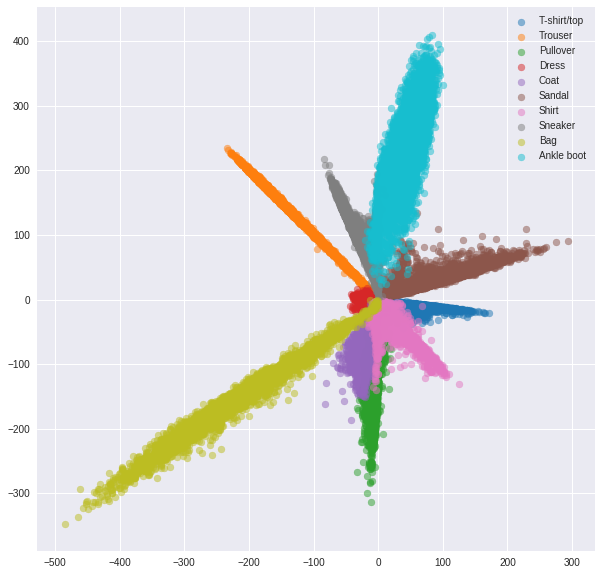

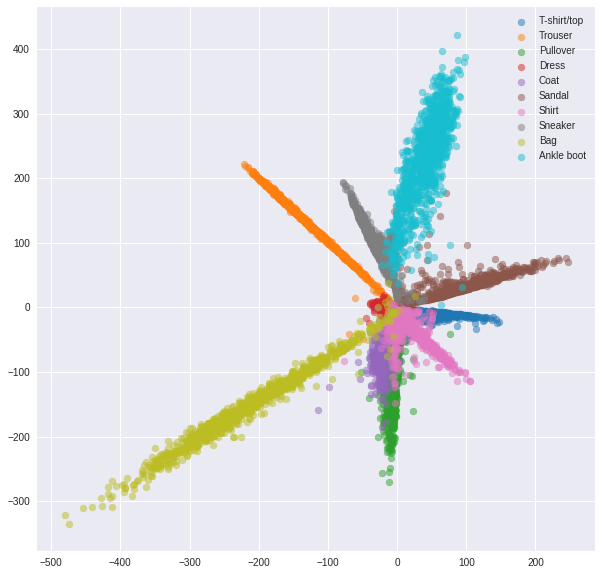

In [6]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Siamese network
We'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

## Steps
1. Create a dataset returning pairs - **SiameseMNIST** class from *datasets.py*, wrapper for MNIST-like classes.
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **siamese** network processing pairs of inputs - **SiameseNet** wrapping *EmbeddingNet*
4. Train the network with **ContrastiveLoss** - *losses.py*

In [0]:
# Set up data loaders
from datasets import SiameseMNIST

# Step 1
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [8]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.269652
Epoch: 1/20. Train set: Average loss: 0.0488
Epoch: 1/20. Validation set: Average loss: 0.0418
Train: [0/60000 (0%)]	Loss: 0.044761
Epoch: 2/20. Train set: Average loss: 0.0376
Epoch: 2/20. Validation set: Average loss: 0.0355
Train: [0/60000 (0%)]	Loss: 0.033609
Epoch: 3/20. Train set: Average loss: 0.0328
Epoch: 3/20. Validation set: Average loss: 0.0330
Train: [0/60000 (0%)]	Loss: 0.033516
Epoch: 4/20. Train set: Average loss: 0.0296
Epoch: 4/20. Validation set: Average loss: 0.0316
Train: [0/60000 (0%)]	Loss: 0.029404
Epoch: 5/20. Train set: Average loss: 0.0270
Epoch: 5/20. Validation set: Average loss: 0.0303
Train: [0/60000 (0%)]	Loss: 0.030470
Epoch: 6/20. Train set: Average loss: 0.0248
Epoch: 6/20. Validation set: Average loss: 0.0301
Train: [0/60000 (0%)]	Loss: 0.022919
Epoch: 7/20. Train set: Average loss: 0.0233
Epoch: 7/20. Validation set: Average loss: 0.0283
Train: [0/60000 (0%)]	Loss: 0.014113
Epoch: 8/20. Train set: Average loss: 0

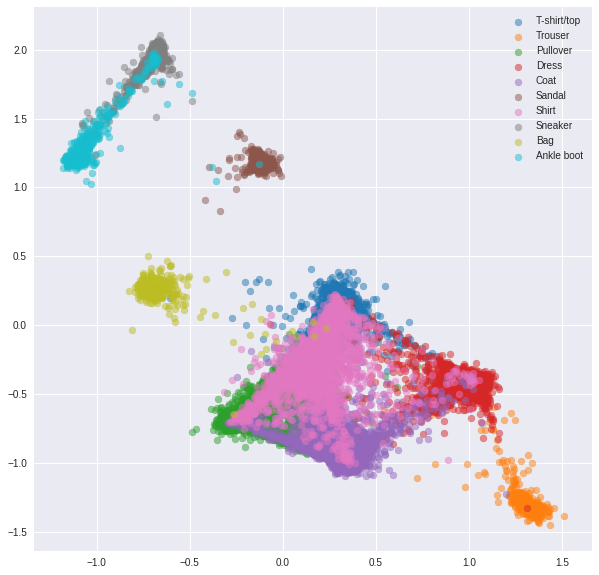

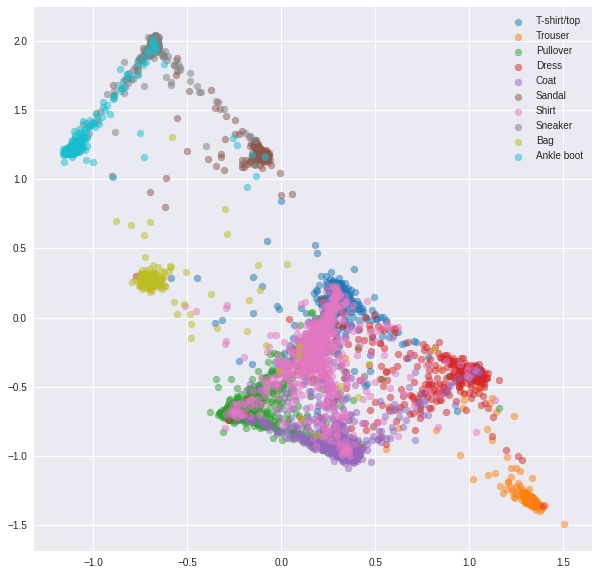

In [9]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## Steps
1. Create a dataset returning triplets - **TripletMNIST** class from *datasets.py*, wrapper for MNIST-like classes
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **triplet** network processing triplets - **TripletNet** wrapping *EmbeddingNet*
4. Train the network with **TripletLoss** - *losses.py*

In [0]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [11]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999610
Epoch: 1/20. Train set: Average loss: 0.1935
Epoch: 1/20. Validation set: Average loss: 0.1546
Train: [0/60000 (0%)]	Loss: 0.135426
Epoch: 2/20. Train set: Average loss: 0.1401
Epoch: 2/20. Validation set: Average loss: 0.1389
Train: [0/60000 (0%)]	Loss: 0.149053
Epoch: 3/20. Train set: Average loss: 0.1189
Epoch: 3/20. Validation set: Average loss: 0.1256
Train: [0/60000 (0%)]	Loss: 0.061009
Epoch: 4/20. Train set: Average loss: 0.1065
Epoch: 4/20. Validation set: Average loss: 0.1117
Train: [0/60000 (0%)]	Loss: 0.058128
Epoch: 5/20. Train set: Average loss: 0.0975
Epoch: 5/20. Validation set: Average loss: 0.1208
Train: [0/60000 (0%)]	Loss: 0.055740
Epoch: 6/20. Train set: Average loss: 0.0905
Epoch: 6/20. Validation set: Average loss: 0.1119
Train: [0/60000 (0%)]	Loss: 0.049064
Epoch: 7/20. Train set: Average loss: 0.0864
Epoch: 7/20. Validation set: Average loss: 0.0961
Train: [0/60000 (0%)]	Loss: 0.099889
Epoch: 8/20. Train set: Average loss: 0

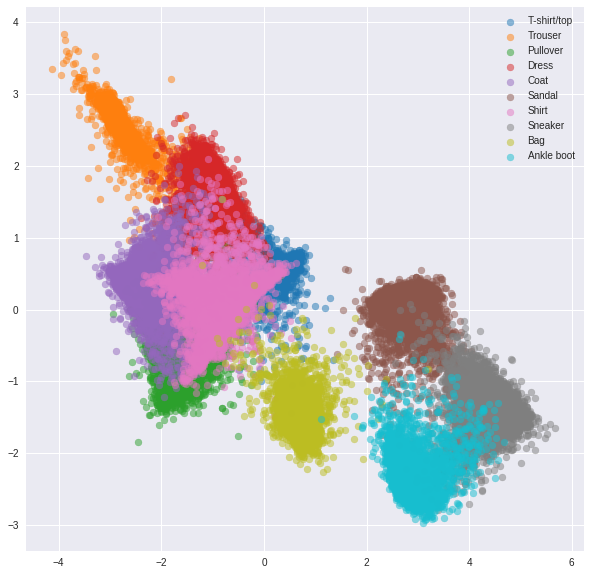

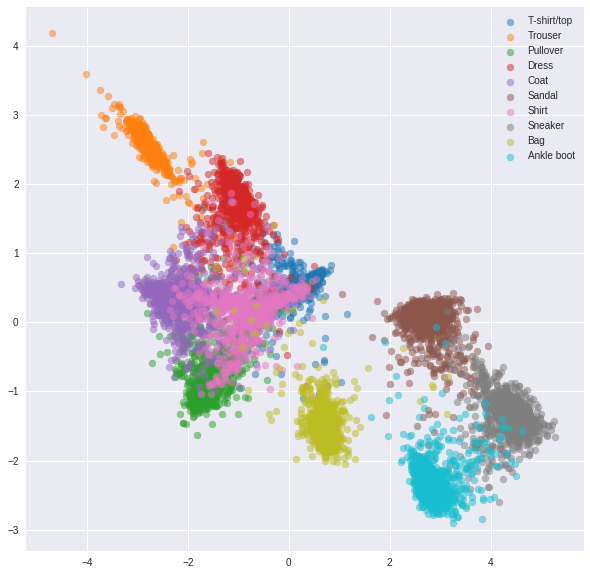

In [12]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datsets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [0]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 250

In [14]:
all_embeddings = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.493135
Epoch: 1/20. Train set: Average loss: 0.2570
Epoch: 1/20. Validation set: Average loss: 0.1978
Train: [0/60000 (0%)]	Loss: 0.186102
Epoch: 2/20. Train set: Average loss: 0.1784
Epoch: 2/20. Validation set: Average loss: 0.1723
Train: [0/60000 (0%)]	Loss: 0.166385
Epoch: 3/20. Train set: Average loss: 0.1493
Epoch: 3/20. Validation set: Average loss: 0.1546
Train: [0/60000 (0%)]	Loss: 0.111484
Epoch: 4/20. Train set: Average loss: 0.1317
Epoch: 4/20. Validation set: Average loss: 0.1510
Train: [0/60000 (0%)]	Loss: 0.142526
Epoch: 5/20. Train set: Average loss: 0.1180
Epoch: 5/20. Validation set: Average loss: 0.1474
Train: [0/60000 (0%)]	Loss: 0.123139
Epoch: 6/20. Train set: Average loss: 0.1042
Epoch: 6/20. Validation set: Average loss: 0.1384
Train: [0/60000 (0%)]	Loss: 0.112338
Epoch: 7/20. Train set: Average loss: 0.0940
Epoch: 7/20. Validation set: Average loss: 0.1358
Train: [0/60000 (0%)]	Loss: 0.090571
Epoch: 8/20. Train set: Average loss: 0

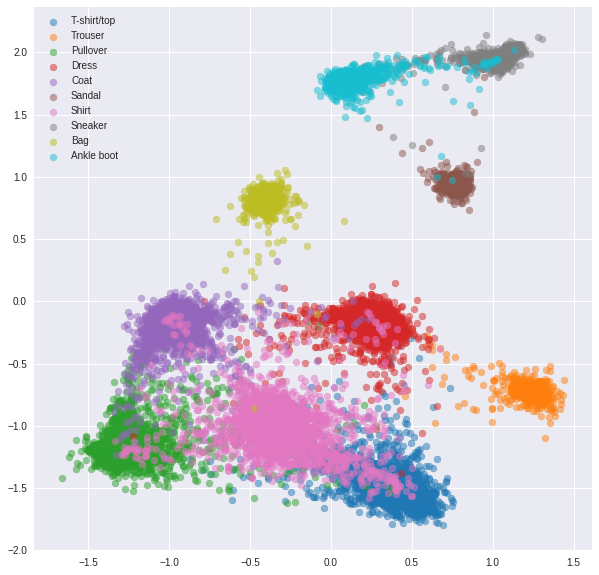

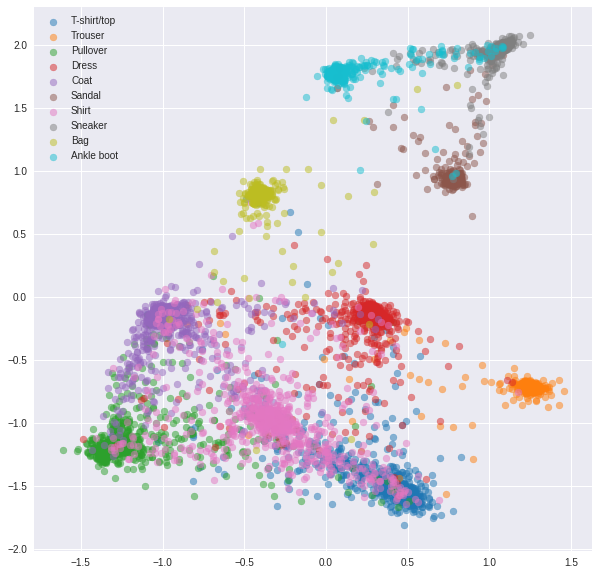

In [15]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datsets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [0]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 150

In [17]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999561	Average nonzero triplets: 3000.0
Train: [37500/60000 (62%)]	Loss: 0.996508	Average nonzero triplets: 2469.0794701986756
Epoch: 1/20. Train set: Average loss: 0.9971	Average nonzero triplets: 2359.9748953974895
Epoch: 1/20. Validation set: Average loss: 0.8417	Average nonzero triplets: 2326.1794871794873
Train: [0/60000 (0%)]	Loss: 0.928094	Average nonzero triplets: 2440.0
Train: [37500/60000 (62%)]	Loss: 0.990674	Average nonzero triplets: 2022.5165562913908
Epoch: 2/20. Train set: Average loss: 0.9954	Average nonzero triplets: 2017.744769874477
Epoch: 2/20. Validation set: Average loss: 1.0652	Average nonzero triplets: 2014.3846153846155
Train: [0/60000 (0%)]	Loss: 1.135839	Average nonzero triplets: 1594.0
Train: [37500/60000 (62%)]	Loss: 0.999547	Average nonzero triplets: 1853.609271523179
Epoch: 3/20. Train set: Average loss: 0.9976	Average nonzero triplets: 1859.5648535564853
Epoch: 3/20. Validation set: Average loss: 1.0837	Average nonzero tripl

Epoch: 14/20. Train set: Average loss: 0.8665	Average nonzero triplets: 865.2259414225941
Epoch: 14/20. Validation set: Average loss: 1.3508	Average nonzero triplets: 1695.923076923077
Train: [0/60000 (0%)]	Loss: 0.851687	Average nonzero triplets: 749.0
Train: [37500/60000 (62%)]	Loss: 0.863456	Average nonzero triplets: 839.7682119205298
Epoch: 15/20. Train set: Average loss: 0.8674	Average nonzero triplets: 838.2092050209205
Epoch: 15/20. Validation set: Average loss: 1.3088	Average nonzero triplets: 1748.974358974359
Train: [0/60000 (0%)]	Loss: 0.812990	Average nonzero triplets: 1120.0
Train: [37500/60000 (62%)]	Loss: 0.842223	Average nonzero triplets: 805.4238410596026
Epoch: 16/20. Train set: Average loss: 0.8511	Average nonzero triplets: 798.7949790794979
Epoch: 16/20. Validation set: Average loss: 1.3487	Average nonzero triplets: 1674.3076923076924
Train: [0/60000 (0%)]	Loss: 0.659690	Average nonzero triplets: 713.0
Train: [37500/60000 (62%)]	Loss: 0.811326	Average nonzero triple

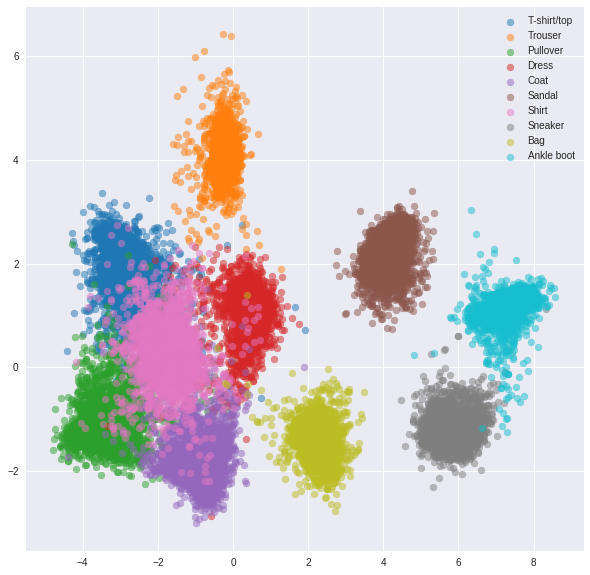

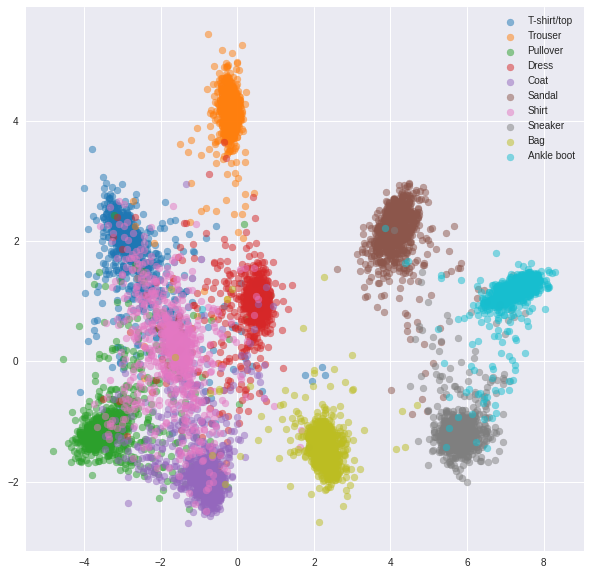

In [18]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

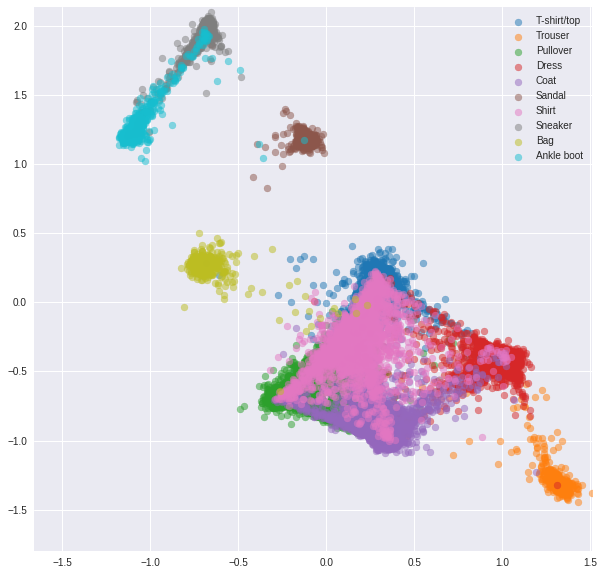

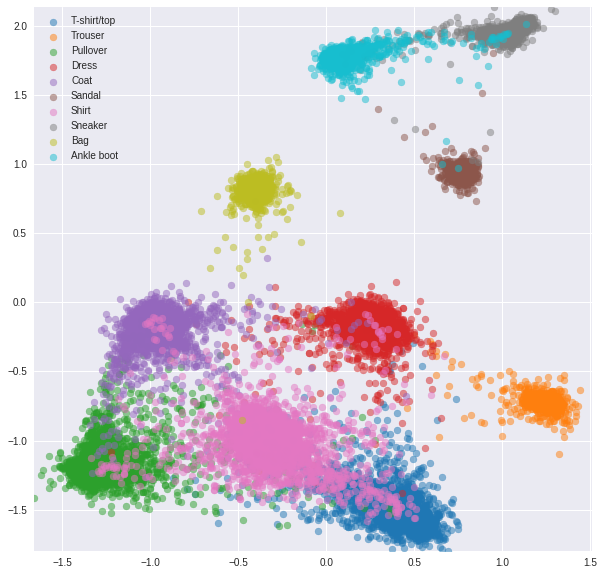

In [19]:
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_ocl, train_embeddings_cl, train_labels_ocl, train_labels_cl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_ocl, val_embeddings_cl, val_labels_ocl, val_labels_cl

x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))

plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

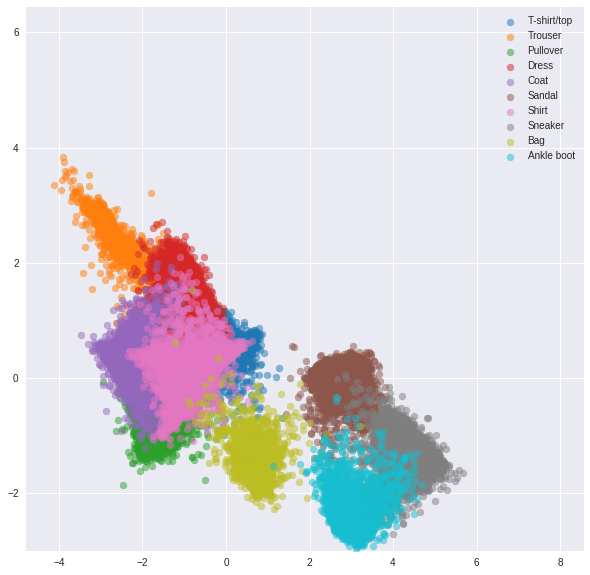

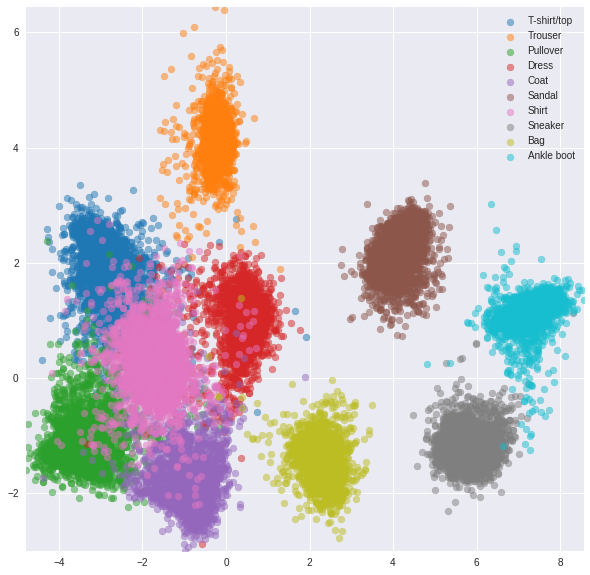

In [20]:
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)